In [1]:
import cv2
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from PIL import Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import random
from tqdm import tqdm
import multiprocessing as mp
import concurrent.futures

In [3]:
# !pip install opencv-python

In [4]:
# ground_truth_path = '/Users/utoarca/Documents/Pearson_AI/isrd-experimental/yes_we_gan/data/0a0f48c0-d349-48da-a0af-1ca9f46cb176.png'
# input_path = '/Users/utoarca/Documents/Pearson_AI/isrd-experimental/yes_we_gan/gen_data/0a0f48c0-d349-48da-a0af-1ca9f46cb176.png'

In [5]:
# # read in and plot image
# im = Image.open(ground_truth_path)
# x_max, y_max = im.size
# ys = np.linspace(0, y_max, num=10) 
# xs = np.linspace(0, x_max, num=25) 
# for num in ys:
#     plt.plot([0, x_max], [num,num], 'k-', lw=1, color='b')
# for num in xs:
#     plt.plot([num, num], [0,y_max], 'k-', lw=1, color='b')
# plt.imshow(im);
# print(im.size)

# plt.gca().set_axis_off()
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)
# plt.margins(0,0)
# plt.savefig('test', bbox_inches='tight', pad_inches=0)


In [27]:
def randomize_params(colors = ['k'], line_widths = [3, 4], slant_direction = ['up', 'down']):
    """Randomize line parameters
    
    Parameters
    ----------
    colors : list, optional
        Blue or black, by default ['b', 'k']
    line_space_range : list, optional
        Number of lines, by default [5,20]
    line_widths : list, optional
        Line width range, by default [0.1, 0.5]
    
    Returns
    -------

    graph_params : dict
        Dictionary containing randomly chosen params
    """
    graph_params = dict()
    graph_params["color_choice"] = random.choice(colors)
    graph_params["slant_direction"] = random.choice(slant_direction)
    graph_params["line_width"] = random.uniform(line_widths[0], line_widths[1])
    graph_params["make_graph"] = random.choice([0,1])
    return graph_params

In [28]:
def add_background(img_path, im, savedir):
    """
    Adds background to transparent PNG, randomly choosing parameters
    
    Parameters
    ----------
    img_path : str
        Path to image
    im : Arr
        Image loaded to array
    savedir : str
       Path to save edites images 
    width : int, optional
        Image width (per sample), by default 960
    height : int, optional
        Image height, by default 240
    dpi : int, optional
        DPI, depends on screen resolution, by default 192
    """
    
    
    if not os.path.exists(savedir):
        os.makedirs(savedir)

    # print('image name', im)
    graph_params = randomize_params()
    plt.close('all')

    img_path = img_path + im
    im = Image.open(img_path)
    x_max, y_max = im.size
    # print('image size', im.size)

    # if the image is narrower than it is tall, it is likely to be a single character
    single_character = x_max < y_max
    
    # print('single character', single_character)
    
    # make the number of lines correspond to the size of the image for more realistic data
    if not single_character:
        if y_max < 90:
            num_lines = random.randint(2,2)
        elif y_max >= 90 and y_max < 200:
            num_lines = random.randint(2,3)
        elif y_max >= 200 and y_max < 300:
            num_lines = random.randint(3,4)
        elif y_max >= 300 and y_max < 400:
            num_lines = random.randint(3,5)
        else:
            num_lines = random.randint(5,7)
    elif single_character:
        # single characters have special conditions
        graph_params["line_width"] = random.uniform(10,13)
        num_lines = random.randint(2,3)
    
    # get some start and stop values for linear spacing
    # subtracted 10 because it is getting cut off to be
    # at the ymax when saving
    start = (y_max/num_lines) - 10
    stop = y_max - 10
    
    ys = np.linspace(start, stop, num=num_lines)
    # print('num ys', len(ys))
    # print('location of y values', ys)
    
    # get the size ratio of the image to compute the number of vertical lines for graph paper
    x_to_y_ratio = x_max/y_max
    
    # sometimes the lined should be slanted slightly for more realistic data
    slant_rand = random.randint(1,100)
    if slant_rand <= 30:
        slanted = True
        slant_amount = random.randint(5,15)
        slant_dir_rand = random.randint(1,100)
        if slant_dir_rand <= 50:
            slant_direction = 'up'
        else:
            slant_direction = 'down'
    else:
        slanted = False 
    
#     if slanted:
#         # print('slanted', slanted)
#         # print('slant direction', slant_direction)
#     else:
#         #print('slanted', slanted)
    
    # make lined paper
    for num in ys:
        # add slants
        if slanted:
            if slant_direction == 'up': 
                num2 = num + slant_amount
            else:
                num2 = num - slant_amount
        # no slant
        else:
            num2 = num
        
#         if num2 < 0:
#             print('num2 is less than 0', num2)
        # if a negative value is chosen for the 2nd number, just don't even plot the line
    
        plt.plot([0, x_max], [num,num2], 'k-', lw=graph_params["line_width"], color=graph_params[ "color_choice" ])

    # print('graph paper status', graph_params["make_graph"])
    # make graph paper
    if graph_params["make_graph"]:
        
        if not single_character:
            # add some noise for where to begin and end the line spacing
            # jitter_num = round(x_max/4)
            start = random.randint(0,10)
            stop = x_max
        else:
            start = (x_max/num_lines) - 10
            stop = x_max - 10
        
        xs = np.linspace(start, stop, num=round(num_lines*x_to_y_ratio))
        # print('location of x values', xs)
        for num in xs:
            plt.plot([num, num], [0,y_max], 'k-', lw=graph_params["line_width"], color=graph_params[ "color_choice" ])
    
    plt.axis('off')
    ### uncomment the line below for just lines!!!
    # im.putalpha(0)
    plt.imshow(im, cmap='Greys_r')
    # plt.show()

    filename = savedir + file
    plt.margins(0,0)
    plt.tight_layout(pad=0)
    plt.savefig(filename, bbox_inches="tight", pad_inches=0)

100%|██████████| 100/100 [00:06<00:00, 17.61it/s]


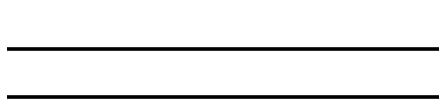

In [33]:
handwriting_dir = '/Users/utoarca/Documents/Pearson_AI/gan_data/pngs_to_make_training_data/batch1/out_new_ME_64_1_none/'
training_files_dir = '/Users/utoarca/Documents/Pearson_AI/gan_data/train/real_preprocessed/real_preprocessed/' 

output_dir = '/Users/utoarca/Documents/Pearson_AI/gan_data/train/noisy_lines_clean_lines_50_50/'

handwriting_files = os.listdir(handwriting_dir) 
training_files = [file for file in os.listdir(training_files_dir) if file.endswith(".jpg")]
training_files = [os.path.splitext(file)[0] for file in training_files]

halfway = round(len(handwriting_files)/2)
print(halfway)
for file in tqdm(handwriting_files[halfway:]):
    
    filename = os.path.splitext(file)[0]
    
    if filename in training_files:
        add_background(handwriting_dir, output_dir)

In [3]:
## convert the images to jpgs
from PIL import Image

path = '/Users/utoarca/Documents/Pearson_AI/gan_data/train/real_preprocessed/real_preprocessed/'
out_path = '/Users/utoarca/Documents/Pearson_AI/gan_data/train/real_preprocessed_pngs/'
for file in tqdm(os.listdir(path)):
    name = os.path.splitext(file)[0]
    im = Image.open(path+file)
    save_name = out_path+name+'.png'
#     save_name = out_path+name+'.jpg'
#     rgb_im = im.convert('RGB')
    im.save(save_name)

100%|██████████| 14574/14574 [01:14<00:00, 196.74it/s]


# Generate data: Input True Backgrounds
### Add a real background behind synthetic handwriting data

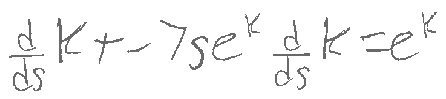

In [19]:
def change_handwriting_color(path, file, savedir):
    
    plt.close('all')
    
    colors = ['red', 'black', 'blue', 'pencil']
    color_selection = random.choice(colors)
    
    img_path = path+file
    img = cv2.imread(img_path)

    # ensure black and white first
    thresh = 110
    maxValue = 255
    ret, img = cv2.threshold(img, thresh, maxValue, cv2.THRESH_BINARY)
    
    # change black pixels to the selected color
    if color_selection == 'red':
        #print('red')
        img[np.where((img==[0,0,0]).all(axis=2))] = [239,0,0]
    elif color_selection == 'blue':
        #print('blue')
        img[np.where((img==[0,0,0]).all(axis=2))] = [34,34,183]
    elif color_selection == 'black':
        #print('black')
        pass
    elif color_selection == 'pencil':
        # print('pencil')
        img[np.where((img==[0,0,0]).all(axis=2))] = [105,105,105]
       
    plt.axis('off')
    plt.imshow(img)
    filename = savedir + file
    plt.margins(0,0)
    plt.tight_layout(pad=0)
    plt.savefig(filename, bbox_inches="tight", pad_inches=0)
    # plt.show()

path = '/Users/utoarca/Documents/Pearson_AI/gan_data/1000_original_data_(old)/'
savedir = '/Users/utoarca/Documents/Pearson_AI/gan_data/synthetic_with_color/'
for file in os.listdir(path):
    change_handwriting_color(path, file, savedir)

In [35]:
training_files_dir = '/Users/utoarca/Documents/Pearson_AI/gan_data/train/real_preprocessed/real_preprocessed/' 
output_dir = '/Users/utoarca/Documents/Pearson_AI/gan_data/train/noisy_lines_clean_lines_50_50/'
training_files = [file for file in os.listdir(training_files_dir) if file.endswith(".jpg")]
new_files = [file for file in os.listdir(output_dir) if file.endswith(".jpg")]

print(len(training_files))
print(len(new_files))

ctr_notin = 0
ctr_in = 0
for file_ in new_files:
    if file_ not in training_files:
        ctr_notin+=1
        os.remove(os.path.join(output_dir, file_))
    else:
        ctr_in+=1

print(ctr_notin)
print(ctr_in)

14574
14574
0
14574



  0%|          | 2/10466 [00:00<15:35, 11.19it/s]

10466



  2%|▏         | 229/10466 [00:25<24:23,  7.00it/s]


  4%|▍         | 415/10466 [00:47<19:23,  8.64it/s]


  6%|▌         | 591/10466 [01:10<17:51,  9.21it/s]


  7%|▋         | 768/10466 [01:32<18:35,  8.69it/s]


  9%|▉         | 927/10466 [01:54<18:50,  8.44it/s]


 11%|█         | 1110/10466 [02:16<22:57,  6.79it/s]


 12%|█▏        | 1278/10466 [02:38<20:29,  7.48it/s]


 14%|█▍        | 1458/10466 [03:00<17:51,  8.41it/s]


 16%|█▌        | 1630/10466 [03:21<17:12,  8.56it/s]


 17%|█▋        | 1812/10466 [03:43<15:53,  9.08it/s]


 19%|█▉        | 2017/10466 [04:06<13:59, 10.07it/s]


 21%|██        | 2204/10466 [04:28<13:41, 10.06it/s]


 23%|██▎       | 2391/10466 [04:49<16:45,  8.03it/s]


 25%|██▍       | 2574/10466 [05:12<16:48,  7.82it/s]


 26%|██▋       | 2752/10466 [05:33<18:57,  6.78it/s]


 28%|██▊       | 2945/10466 [05:55<14:44,  8.50it/s]


 30%|███       | 3148/10466 [06:19<14:14,  8.56it/s]


 32%|███▏      | 3336/10466 [06:42<15:52,  7.49it/s]


 34%|███▎      | 3518/10466 [07:03<12:12,  9.49it/s]


 36%|███▌      | 3718/10466 [07:26<12:40,  8.87it/s]


 37%|███▋      | 3902/10466 [07:47<12:10,  8.98it/s]


 39%|███▉      | 4086/10466 [08:10<13:30,  7.87it/s]


 41%|████      | 4288/10466 [08:33<12:34,  8.19it/s]


 43%|████▎     | 4452/10466 [08:53<12:45,  7.85it/s]


 44%|████▍     | 4616/10466 [09:17<11:43,  8.32it/s]


 46%|████▌     | 4776/10466 [09:40<16:26,  5.77it/s]


 47%|████▋     | 4934/10466 [10:04<12:53,  7.15it/s]


 49%|████▊     | 5085/10466 [10:27<11:38,  7.70it/s]


 50%|█████     | 5239/10466 [10:49<15:00,  5.80it/s]


 52%|█████▏    | 5395/10466 [11:11<15:16,  5.53it/s]


 53%|█████▎    | 5546/10466 [11:35<12:47,  6.41it/s]


 54%|█████▍    | 5700/10466 [11:58<09:41,  8.20it/s]


 56%|█████▌    | 5853/10466 [12:20<11:24,  6.74it/s]


 57%|█████▋    | 6008/10466 [12:43<12:10,  6.10it/s]


 59%|█████▉    | 6166/10466 [13:09<09:25,  7.60it/s]


 60%|██████    | 6322/10466 [13:31<09:40,  7.13it/s]


 62%|██████▏   | 6470/10466 [13:54<09:46,  6.81it/s]


 63%|██████▎   | 6626/10466 [14:17<10:58,  5.83it/s]


 65%|██████▍   | 6784/10466 [14:40<09:58,  6.15it/s]


 66%|██████▋   | 6939/10466 [15:03<14:51,  3.95it/s]


 68%|██████▊   | 7103/10466 [15:25<08:08,  6.89it/s]


 69%|██████▉   | 7261/10466 [15:47<06:42,  7.97it/s]


 71%|███████   | 7421/10466 [16:09<07:27,  6.80it/s]


 72%|███████▏  | 7580/10466 [16:33<06:37,  7.26it/s]


 74%|███████▍  | 7738/10466 [17:00<07:21,  6.18it/s]


 75%|███████▌  | 7895/10466 [17:23<06:13,  6.89it/s]


 77%|███████▋  | 8050/10466 [17:45<06:08,  6.55it/s]


 78%|███████▊  | 8206/10466 [18:07<05:29,  6.87it/s]


 80%|███████▉  | 8361/10466 [18:30<05:50,  6.00it/s]


 82%|████████▏ | 8534/10466 [18:52<04:25,  7.29it/s]


 83%|████████▎ | 8716/10466 [19:13<03:30,  8.30it/s]


 85%|████████▌ | 8901/10466 [19:35<03:09,  8.27it/s]


 87%|████████▋ | 9087/10466 [19:58<02:38,  8.71it/s]


 88%|████████▊ | 9257/10466 [20:19<02:06,  9.59it/s]


 90%|█████████ | 9446/10466 [20:41<01:53,  9.02it/s]


 92%|█████████▏| 9617/10466 [21:08<01:31,  9.25it/s]


 93%|█████████▎| 9785/10466 [21:30<01:36,  7.06it/s]


 95%|█████████▌| 9947/10466 [21:53<01:12,  7.17it/s]


 97%|█████████▋| 10103/10466 [22:13<00:47,  7.64it/s]


 98%|█████████▊| 10261/10466 [22:34<00:29,  6.86it/s]


100%|█████████▉| 10416/10466 [22:54<00:07,  6.85it/s]


100%|██████████| 10466/10466 [23:01<00:00,  7.58it/s]

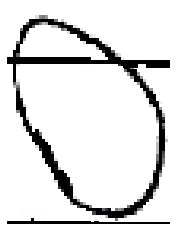

In [26]:
from PIL import Image
import os
import random
import matplotlib.pyplot as plt

handwriting_dir = '/Users/utoarca/Documents/Pearson_AI/gan_data/pngs_to_make_training_data/batch1/out_new_ME_64_1_none/'
training_files_dir = '/Users/utoarca/Documents/Pearson_AI/gan_data/train/real_preprocessed/real_preprocessed/' 

graphs_dir = '/Users/utoarca/Documents/Pearson_AI/gan_data/backgrounds/thresholded/graph/'
graphs_otsu_dir = '/Users/utoarca/Documents/Pearson_AI/gan_data/backgrounds/thresholded/otsu/graph/'
lined_dir = '/Users/utoarca/Documents/Pearson_AI/gan_data/backgrounds/thresholded/lined/'
lined_otsu_dir = '/Users/utoarca/Documents/Pearson_AI/gan_data/backgrounds/thresholded/otsu/lined/'

output_dir = '/Users/utoarca/Documents/Pearson_AI/gan_data/train/noisy_lines_clean_lines_50_50/'

handwriting_files = os.listdir(handwriting_dir) 
training_files = [file for file in os.listdir(training_files_dir) if file.endswith(".jpg")]
training_files = [os.path.splitext(file)[0] for file in training_files]
graph_files = [file for file in os.listdir(graphs_dir) if file.endswith(".jpg")]
lined_files = [file for file in os.listdir(lined_dir) if file.endswith(".jpg")]

halfway = round(len(handwriting_files)/2)
print(halfway)
for file in tqdm(handwriting_files[0:halfway]):
    
    filename = os.path.splitext(file)[0]
    
    if filename in training_files:

        plt.close('all')
        # get images
        img = Image.open(os.path.join(handwriting_dir, file))

        # decide which background to use randomly
        rand = random.randint(1,100)

        if rand >= 25:
            selected_background = random.choice(lined_files)
            backgrounds_dir = lined_dir
        else:
            selected_background = random.choice(graph_files)
            backgrounds_dir = graphs_dir

    background = Image.open(os.path.join(backgrounds_dir,selected_background))
    background_width, background_height = background.size

    # sometimes crop the background to get rid of the side lines on lined paper
    rand_background = random.randint(1,100)
    if rand_background >= 20:
        left = 800
        top = 800
        right = background_width
        bottom = background_height
        # crop image to above dimension  
        background = background.crop((left, top, right, bottom)) 

    # get size to crop background to
    width, height = img.size  
    background_width, background_height = background.size

    if background_width > width:
        # setting the points for cropped image to match handwriting size
        left = 0
        top = 0
        right = width
        bottom = height

        # crop image to above dimension  
        background = background.crop((left, top, right, bottom)) 

        # paste val image onto background
        background.paste(img, (0, 0), img)
        # save image
        plt.imshow(background)
        plt.axis('off')
        # plt.show()

        save_filename = os.path.join(output_dir, filename) + '.jpg'
        plt.savefig(save_filename, bbox_inches='tight', pad_inches=0)

    else:
    #     # save image
        plt.imshow(img)
        plt.axis('off')
        # plt.show()

        save_filename = save_filename = os.path.join(output_dir, filename) + '.jpg'
        plt.savefig(save_filename, bbox_inches='tight', pad_inches=0)

# Threshold the backgrounds to see if we can get some variation and noisy lines

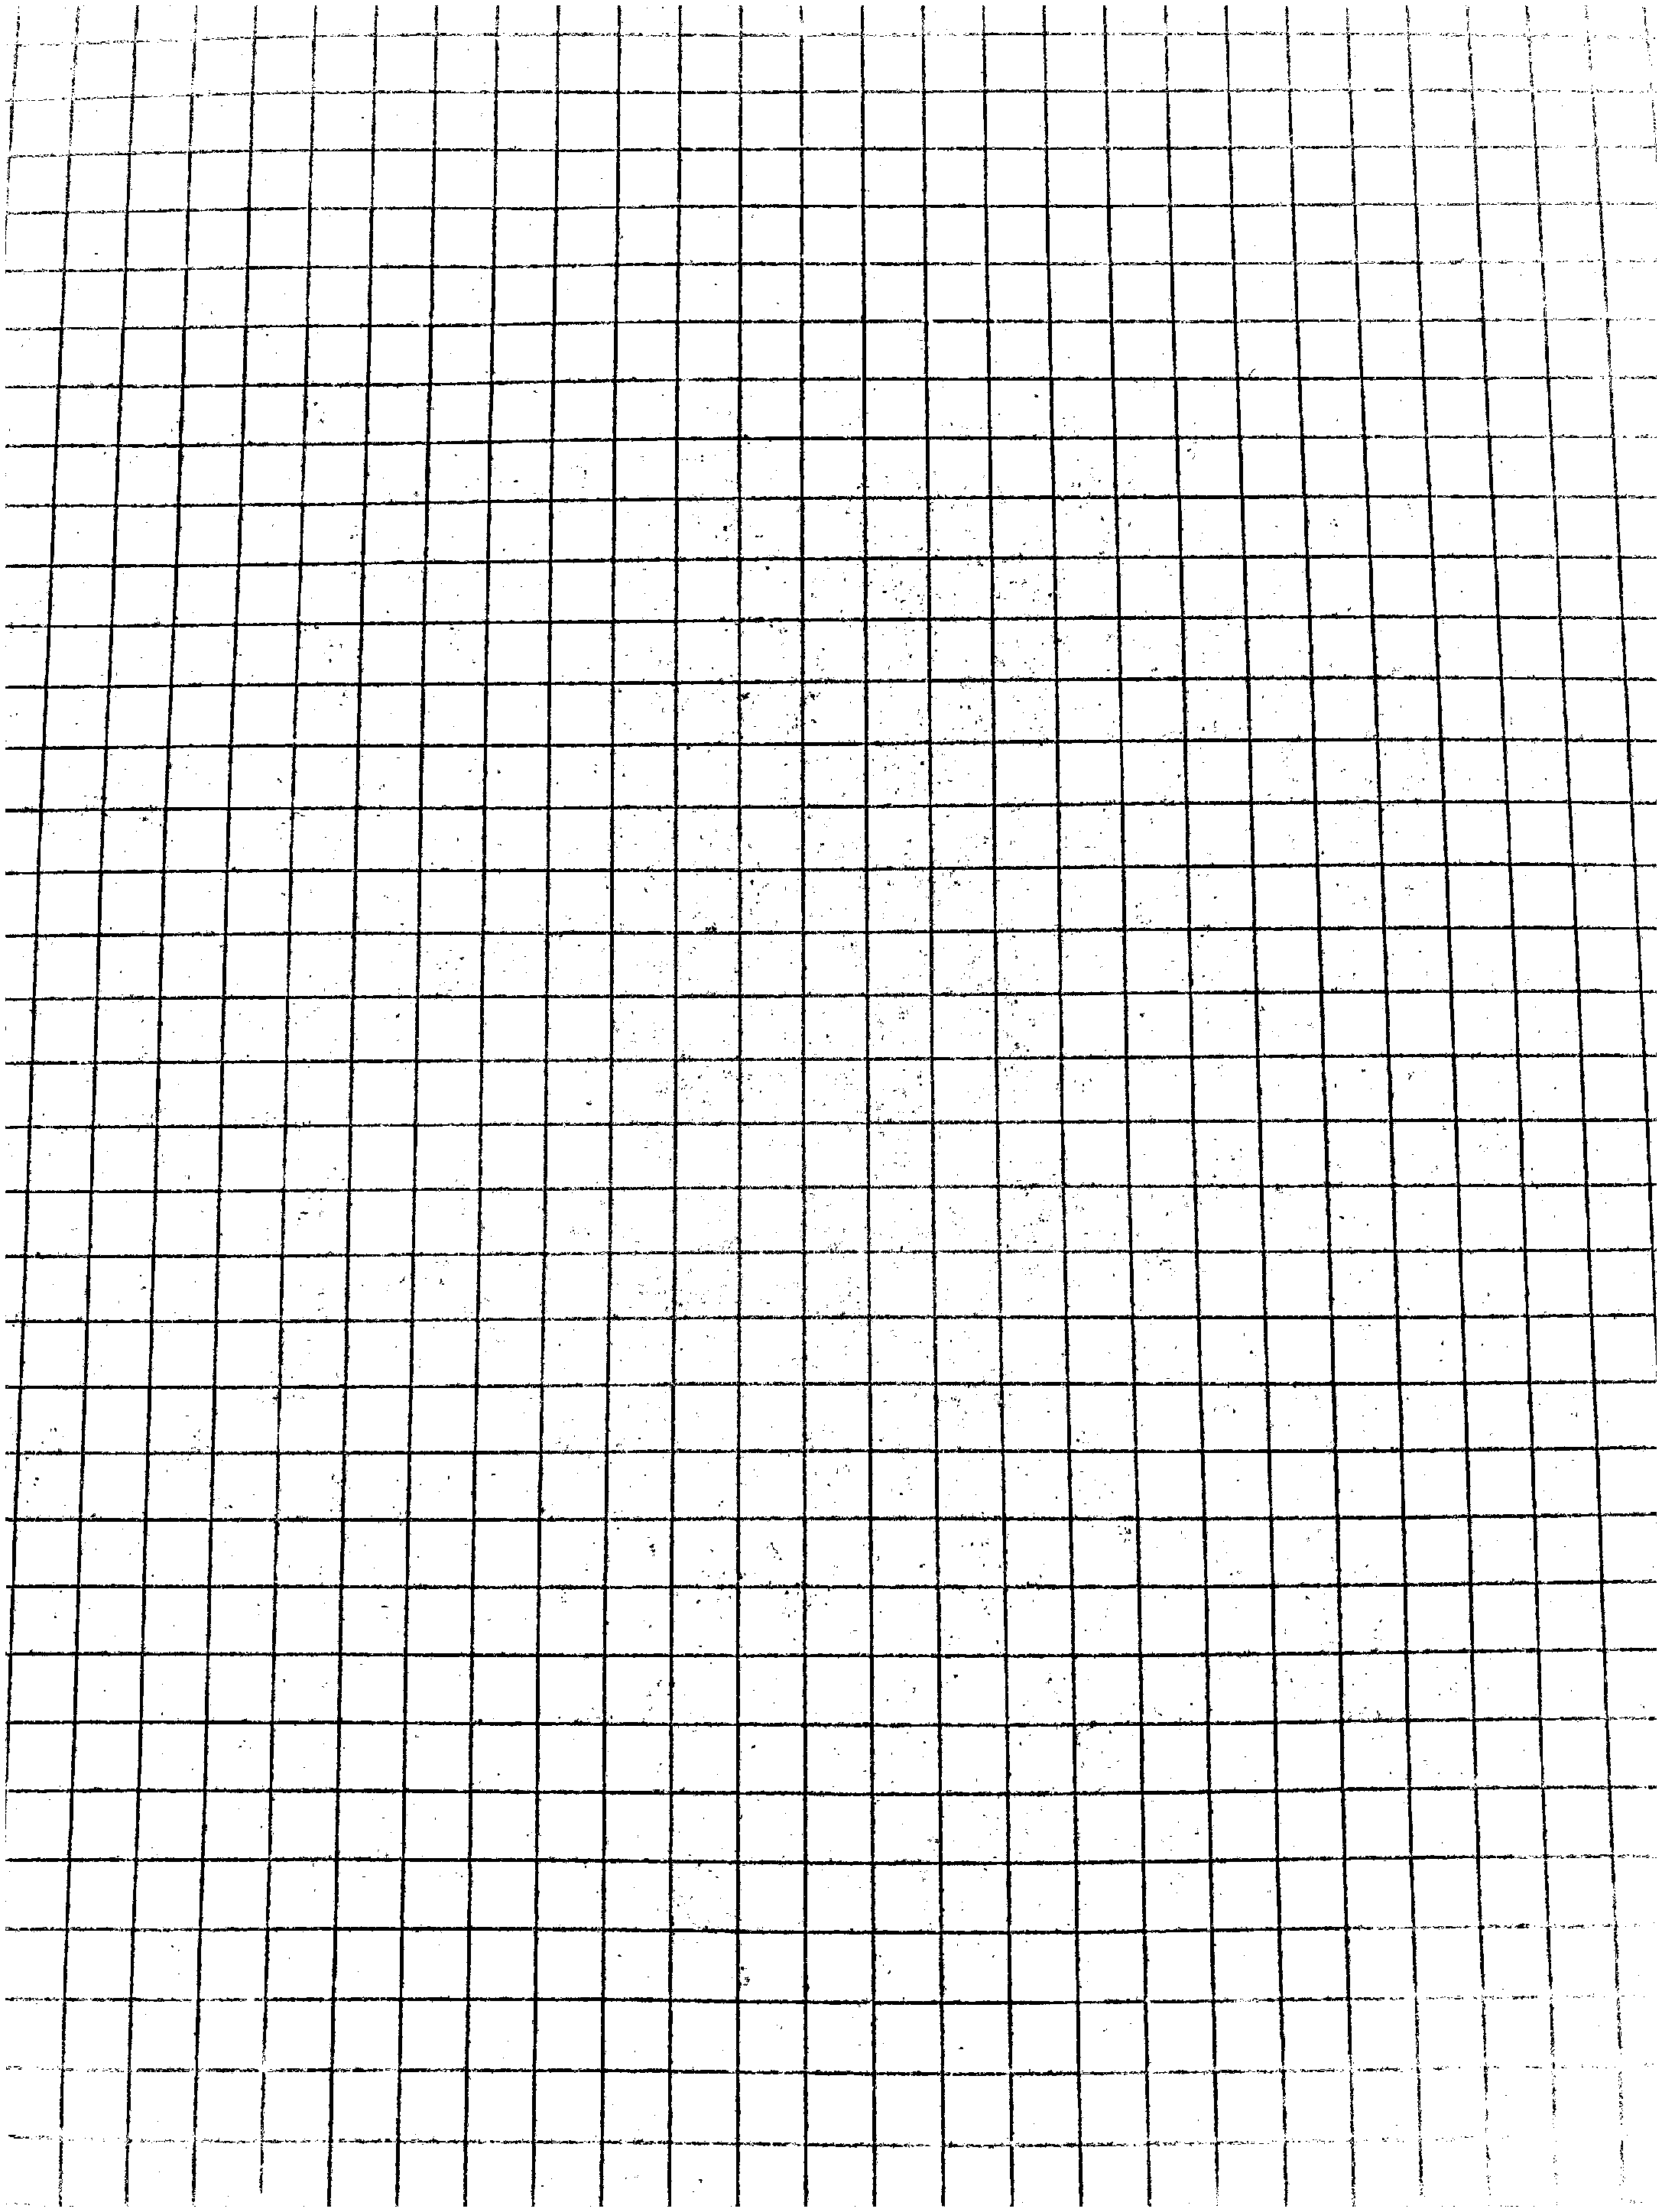

In [3]:
backgrounds_dir = '/Users/utoarca/Documents/Pearson_AI/gan_data/backgrounds/graph_and_lined/'
images = os.listdir(backgrounds_dir)
savedir = '/Users/utoarca/Documents/Pearson_AI/gan_data/backgrounds/thresholded/'

# for num in tqdm(range(0, 15)):
    
for file in images:
    plt.close('all')

    if file.endswith(".jpg"):

        file_path = os.path.join(backgrounds_dir, file)
        img = cv2.imread(file_path)
    #         plt.axis('off')
    #         plt.imshow(img)
    #         plt.show()

        # convert to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Remove noise with bilateral filter (effective in noise removal while keeping edges sharp)
        gray_img_filt = cv2.bilateralFilter(gray_img, d=7, sigmaColor=75, sigmaSpace=75)

        # dilate the image in order to get ride of the math
        dilated_img = cv2.dilate(gray_img_filt, np.ones((10,10), np.uint8))

        # suppress anything else with a blur function
        blur_img = cv2.medianBlur(dilated_img, 21)

        # calculate difference
        diff_img = 255 - cv2.absdiff(gray_img, blur_img)

        #apply a simple threshold
#             thresh = random.randint(190,235)
#             maxValue = 255
#             ret, thresh_img = cv2.threshold(diff_img, thresh, maxValue, cv2.THRESH_BINARY)

        thresh = 0
        maxValue = 255
        ret, thresh_img = cv2.threshold(diff_img, thresh, maxValue, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

        plt.figure(figsize=(50,40))
        plt.axis('off')
        plt.imshow(thresh_img,cmap='Greys_r');
        # plt.show()

        filename = savedir + 'otsu_' + file
        plt.margins(0,0)
        plt.tight_layout(pad=0)
        plt.savefig(filename, bbox_inches="tight", pad_inches=0)
